In [10]:
import os
import random
SEED_NUMBER = 1998

random.seed(SEED_NUMBER)

def parse_annotation(annotation_file_path, shuffle=False):
    with open(annotation_file_path, "rt") as file:
        lines = [line.replace("\n", "") for line in file.readlines()]
        image_label = [[line.split(" ")[0], line.split(" ")[2]] for line in lines]
    if shuffle:
        random.shuffle(image_label)
    return image_label


TRAINVAL_ANNOTATION_TXT = os.path.join(
    "dataset", "pet", "annotations", "trainval.txt"
)
trainval_label = parse_annotation(TRAINVAL_ANNOTATION_TXT, shuffle=True)
trainval_label

[['miniature_pinscher_119', '2'],
 ['chihuahua_164', '2'],
 ['Russian_Blue_139', '1'],
 ['basset_hound_172', '2'],
 ['english_setter_158', '2'],
 ['Russian_Blue_16', '1'],
 ['german_shorthaired_167', '2'],
 ['miniature_pinscher_151', '2'],
 ['german_shorthaired_119', '2'],
 ['miniature_pinscher_188', '2'],
 ['saint_bernard_100', '2'],
 ['german_shorthaired_170', '2'],
 ['Ragdoll_159', '1'],
 ['english_setter_137', '2'],
 ['Maine_Coon_205', '1'],
 ['leonberger_155', '2'],
 ['english_cocker_spaniel_102', '2'],
 ['British_Shorthair_163', '1'],
 ['British_Shorthair_114', '1'],
 ['pomeranian_168', '2'],
 ['Ragdoll_190', '1'],
 ['great_pyrenees_100', '2'],
 ['american_pit_bull_terrier_187', '2'],
 ['japanese_chin_108', '2'],
 ['Ragdoll_174', '1'],
 ['english_setter_153', '2'],
 ['Egyptian_Mau_155', '1'],
 ['Sphynx_125', '1'],
 ['Bombay_13', '1'],
 ['german_shorthaired_179', '2'],
 ['boxer_179', '2'],
 ['scottish_terrier_119', '2'],
 ['german_shorthaired_160', '2'],
 ['great_pyrenees_173', '2

In [11]:
boundary = int(len(trainval_label) * 0.8)
train_label = trainval_label[:boundary]
validation_label = trainval_label[boundary:]
print(len(trainval_label))
print(len(train_label))
print(len(validation_label))

3680
2944
736


data.shape (200, 200, 3)
label.shape (200, 200)
1    28871
0     6402
2     4727
dtype: int64
1


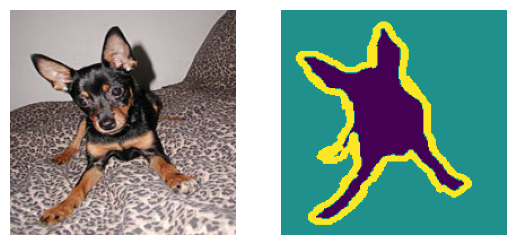

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np


ANNOTATION_DIR = os.path.join("dataset", "pet", "annotations", "trimaps")
TRAIN_DIR = os.path.join("dataset", "pet", "images")
ANNOTATION_EXTENSION = ".png"
TRAIN_EXTENSION = ".jpg"
IMAGE_SIZE = (200, 200)


def image_dataset_generator(filename_to_label):
    for filename, label in filename_to_label:
        yield (
            np.asarray(
                Image.open(os.path.join(TRAIN_DIR, filename + TRAIN_EXTENSION))
                .resize(IMAGE_SIZE)
                .convert("RGB")
            ),
            (np.asarray(
                Image.open(
                    os.path.join(ANNOTATION_DIR, filename + ANNOTATION_EXTENSION)
                ).resize(IMAGE_SIZE)
            )
            - 1, int(label)-1),
        )


import pandas as pd


for data, labels in image_dataset_generator(trainval_label):
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(data)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(labels[0])
    print("data.shape", data.shape)
    print("label.shape", labels[0].shape)
    print(pd.Series(labels[0].flatten()).value_counts())
    print(labels[1])
    break


In [30]:
import tensorflow as tf
import numpy as np

def get_dataset(filename_to_label, output_signature):
    return tf.data.Dataset.from_generator(
        lambda :image_dataset_generator(filename_to_label),
        output_signature=output_signature,
    )

output_signature = (
    tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    (tf.TensorSpec(shape=IMAGE_SIZE, dtype=tf.int32), tf.TensorSpec(shape=None, dtype=tf.int32)),
)


train_dataset = get_dataset(
    train_label, output_signature
)
validation_dataset = get_dataset(
    validation_label, output_signature
)
train_dataset


<FlatMapDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(200, 200), dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)))>

In [31]:
def get_model(img_size: tuple, num_classes: int):
    input_tensor = tf.keras.Input((*img_size, 3))
    # Preprocessing stage
    x = tf.keras.layers.Rescaling(1.0 / 255)(input_tensor)
    # Encoding stage
    x = tf.keras.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    encoding_out = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    # Decoding stage
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(
        encoding_out
    )
    x = tf.keras.layers.Conv2DTranspose(
        256, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(
        128, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(
        64, 3, strides=2, activation="relu", padding="same"
    )(x)
    # Segmenting stage
    seg_out = tf.keras.layers.Conv2D(
        num_classes, 3, activation="softmax", padding="same"
    )(x)
    # Classification stage
    y = tf.keras.layers.Flatten()(encoding_out)
    clf_out = tf.keras.layers.Dense(1, activation="sigmoid")(y)
    return tf.keras.Model(inputs=[input_tensor], outputs=[seg_out, clf_out])


model = get_model(IMAGE_SIZE, 3)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 200, 200, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 100, 100, 64  1792        ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(),
        tf.keras.losses.BinaryCrossentropy(),
    ],
    metrics=[[], [tf.keras.metrics.BinaryAccuracy()]]
)


In [33]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("", save_best_only=True)
]

In [34]:
history = model.fit(
    train_dataset.shuffle(4096).repeat(1).batch(32),
    epochs=50,
    validation_data=validation_dataset.repeat(1).batch(32),
    callbacks=callbacks
)


Epoch 1/50


2022-10-26 01:46:06.309998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1120 of 4096
2022-10-26 01:46:16.307905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2033 of 4096
2022-10-26 01:46:26.310197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2925 of 4096
2022-10-26 01:46:26.512908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-26 01:46:32.493532: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-26 01:46:37.601560: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 01:46:40.742656: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates 

     92/Unknown - 77s 299ms/step - loss: 13.6871 - conv2d_20_loss: 12.8544 - dense_2_loss: 0.8326 - dense_2_binary_accuracy: 0.6525

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 92s 470ms/step - loss: 13.6871 - conv2d_20_loss: 12.8544 - dense_2_loss: 0.8326 - dense_2_binary_accuracy: 0.6525 - val_loss: 1.5059 - val_conv2d_20_loss: 0.8732 - val_dense_2_loss: 0.6326 - val_dense_2_binary_accuracy: 0.6997
Epoch 2/50


2022-10-26 01:47:35.785271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 675 of 4096
2022-10-26 01:47:45.788479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1343 of 4096
2022-10-26 01:47:55.783414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2010 of 4096
2022-10-26 01:48:05.785764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2704 of 4096
2022-10-26 01:48:08.920960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


63/92 [===================>..........] - ETA: 8s - loss: 1.5339 - conv2d_20_loss: 0.8702 - dense_2_loss: 0.6637 - dense_2_binary_accuracy: 0.6513

KeyboardInterrupt: 